# Lab Four: Multi-Layer Perceptron
By Saaketh Koka, Vedant Nilabh, and Rayaan Irani 

In this lab, we will make a multi-layer perceptron (a type of Neural Network) which takes in data provided by the US Census Bearueau on a county-wide basis to determine the child poverty level in the county. 

## Load, Split, and Balance

In [9]:
#Import statements for the program 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

Median number of census tracts per county: 9.0
Mean number of census tracts per county: 37.21494370522006


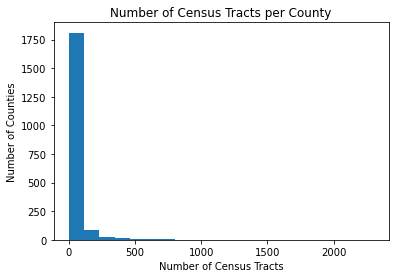

In [15]:
#Loads in all of the data into a Pandas Data Frame
df = pd.read_csv("acs2017_census_tract_data.csv")

df.dropna(inplace=True) #Removes rows that have missing values 

#This converts all of the string values into numerical values
le = preprocessing.LabelEncoder()
df['State'] = le.fit_transform(df['State'])
df['County'] = le.fit_transform(df['County'])

counts = list(df["County"].groupby(df["County"]).count())
plt.hist(counts, bins = 20)
plt.title("Number of Census Tracts per County")
plt.xlabel("Number of Census Tracts")
plt.ylabel("Number of Counties")

#Shows the median number of census tracts per county
print("Median number of census tracts per county: " + str(np.median(counts)))

#Shows the mean number of census tracts per county
print("Mean number of census tracts per county: " + str(np.mean(counts)))


Counites should be kept as a feature. This is becuase counties like states play a role in funding poverty relief programs. The extent to which these programs are funded is a result of the relative wealth of the county (as most county tax revenue is derived from property taxes). Due to this, it is possible that two census tracks that are very similar in other data types may differ greatly in poverty levels because one is surronded by a richer area and thus gets more county funding and the other does not. 

Text(0, 0.5, 'Number of Census Tracts')

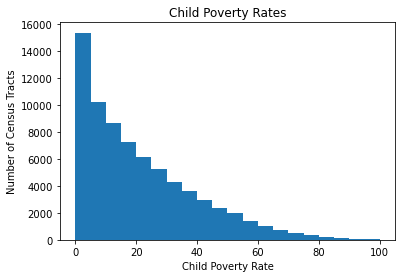

In [16]:
# Create histogram of child poverty rates
plt.hist(df["ChildPoverty"], bins = 20)
plt.title("Child Poverty Rates")
plt.xlabel("Child Poverty Rate")
plt.ylabel("Number of Census Tracts")


As can seen by the chart, the child poverty rates amongst census tracks do not follow a uniform or Gausian distribution. The data shows a mode near zero with the number of census tracks suffering a higher rates falling steadly from there. Due to the data being monomodal, there is no clear points to split the data into classes from Child Poverty Rates themselves. For this reason, we are spliting the data into classes each with an equal number of census tracks. This will allow us to use the full dataset for training and testing instead of having to throw away data to keep the classes balanced.

In [17]:
# Discreatizing the Unemployment Variable into 4 classes, 0,1,2,3
classes = pd.qcut(df['ChildPoverty'], 4, labels = [0,1,2,3])
df['ChildPoverty'] = classes

# Dropping the TractId column because it is useless for our model
df.drop('TractId', axis = 1, inplace = True)

# Splitting the data so that each set has almost an equal number of each class
X_train, X_test, y_train, y_test = train_test_split(df.drop('ChildPoverty', axis = 1), df['ChildPoverty'], test_size = 0.2, stratify = df['ChildPoverty'])

# Converting the data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Initial Modeling

In [35]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        # Mini Batch params:
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

In [44]:
hyper_params = {'n_hidden': 30,
            'C': 0.1, 'epochs': 100, 'eta': 0.001,
            'alpha': 0.001, 'decrease_const': 1e-5, 'minibatches': 50,
            'shuffle': True, 'random_state': 1}
model1 = TwoLayerPerceptronBase(**hyper_params)
model1.fit(X_train,y_train,print_progress=1,XY_test=(X_test,y_test))


Epoch: 100/100

Test accuracy: 24.98%
Value Counts of classes predicted: 
1    14541
2        3
dtype: int64


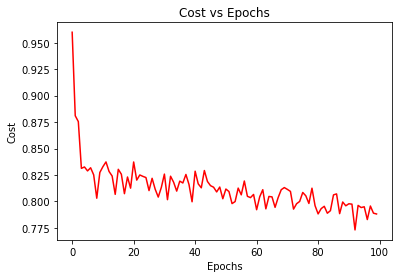

In [45]:
y_pred = model1.predict(X_test)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
# print out the value counts of each item in y_pred:
print("Value Counts of classes predicted: ")
print(pd.Series(y_pred).value_counts())
cost_avgs = np.mean(model1.cost_,axis=1)
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.show()

This model is run without any scaling or one-hot encoding of the features. While the cost decreases slightly over the 100 epochs, the accuracy is very low. When testing the model, the model almost excusivley predicts a certain class for all of the data suggesting that the model is training to simply predict a certain class. Hopefully scaling the feature data can fix this issue.

In [46]:
# Scaling the feature data that is fit X_train data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)
X_test_scl = scaler.transform(X_test)

# Running with the same hyperparameters as above
model2 = TwoLayerPerceptronBase(**hyper_params)
model2.fit(X_train_scl,y_train,print_progress=1,XY_test=(X_test_scl,y_test))

Epoch: 100/100

Test accuracy: 72.97%
Value Counts of classes predicted: 
2    3746
3    3741
1    3621
0    3436
dtype: int64


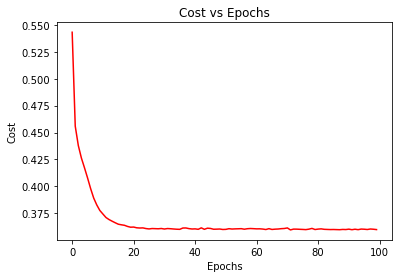

In [48]:
y_pred_scl = model2.predict(X_test_scl)
print('Test accuracy: %.2f%%' % (accuracy_score(y_test, y_pred_scl)*100))
# print out the value counts of each item in y_pred_scl:
print("Value Counts of classes predicted: ")
print(pd.Series(y_pred_scl).value_counts())
cost_avgs = np.mean(model2.cost_,axis=1)
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('Cost vs Epochs')
plt.show()

This time the model does a lot better. The cost decreases significantly over the 100 epochs and the model actually predicts multiple classes. Also, the cost converges in about 30 epochs so we should stop training early to prevent overfitting. Now, lets one-hot encode the two categorical features and see if that improves the model even further.

## Modeling

## Exceptional Work